<div style="font-size:12pt; font-weight:bold;">Netanomics Collaborative Environment: Bayesian Workflow Demonstration</div>
<div style="font-size:12pt;">Richard McElreath's (2021) <em>Two Moms</em> Analysis</div>
<div style="font-size:12pt;">Jonathan H. Morgan, Ph.D.</div>
<div style="font-size:12pt;">22 January 2025</div>

<div style="font-size:12pt; font-weight:bold;">Preamble</div>

In [1]:
#Python Packages
import sys
import os
import subprocess
import pexpect

from PIL import Image, ImageChops
from IPython.display import display

In [2]:
#Loading Julia
from julia.api import Julia
jl = Julia(compiled_modules=False)

from julia import Main
Main.eval('println("Hello from Julia with workaround!")')

Hello from Julia with workaround!


In [3]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...


In [4]:
%%julia
#   Activating Local Environment
    cd("/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration")
    using Pkg
    Pkg.activate("julia_env")
    Pkg.status()

#   Loading Packages
    using DataFrames
    using julia_env

  Activating project at `/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/julia_env`


Project julia_env v0.1.0
Status `/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/julia_env/Project.toml`
  [336ed68f] CSV v0.10.15
  [8be319e6] Chain v0.6.0
  [861a8166] Combinatorics v1.0.2
  [a93c6f00] DataFrames v1.7.0
  [31c24e10] Distributions v0.25.117
  [7073ff75] IJulia v1.26.0
  [438e738f] PyCall v1.96.4
  [6f49c342] RCall v0.14.6
  [10745b16] Statistics v1.11.1
  [44cfe95a] Pkg v1.11.0
  [de0858da] Printf v1.11.0
  [9a3f8284] Random v1.11.0


In [7]:
# Loading R
%load_ext rpy2.ipython

/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/python_env/lib/python3.8/site-packages/rpy2/ipython/rmagic.py:85: UserWarning: The Python package `pandas` is strongly recommended when using `rpy2.ipython`. Unfortunately it could not be loaded, as we did not manage to load `numpy` in the first place (error: No module named 'numpy').
  warnings.warn('The Python package `pandas` is strongly '


In [8]:
%%R
# Options
    options(stringsAsFactors = FALSE)
    options(scipen=999)
    options(mc.cores = parallel::detectCores())

#   Packages
    library(cmdstanr)       #Used to run cmdstan from R
    library(bridgesampling) #Used to calculate Model Marginal Likelihoods & Bayes Factors
    library(bayesplot)      #Used to generate Bayesian diagnostic plots
    library(dplyr)          #Data Management
    library(posterior)      #Used to sample posterior distribution
    library(loo)            #Used for Leave-One-Out Cross Validation
    library(knitr)          #Used here to generate Dataplot Style Axes
    library(sysfonts)       #Used to link to system fonts
    library(extrafont)      #Used to load system fonts
    library(showtext)       #Used to display font in images

This is cmdstanr version 0.8.1
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- Use set_cmdstan_path() to set the path to CmdStan
- Use install_cmdstan() to install CmdStan
This is bayesplot version 1.11.1
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

This is posterior version 1.6.0

Attaching package: ‘posterior’

The following object is masked from ‘package:bayesplot’:

    rhat

The following objects are masked from ‘package:stats’:

    mad, sd, var

The following objects are masked from ‘package:base’:

    %in%, match

This is loo version 2.8.0
- Online documentation and vignettes at mc-stan.org/loo
- As 

In [ ]:
%%R
#   Loading Fonts
    font_add("Palatino Linotype", "/usr/share/fonts/truetype/Palatino Linotype/Palatino Linotype.ttf")
    loadfonts(device = "pdf")

#   Checking that I am pointing to cmdstan
    set_cmdstan_path("/home/jhm18/cmdstan")
    cmdstan_path()
    cmdstan_version()

#   Setting Seed
    set.seed(10271998) 

#   Sourcing Functions
    source("/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/R_functions/Bayesian_Modeling_Support_Functions.R")

<div style="font-size:12pt; font-weight:bold;">Proposed Causal Model</div>

In [13]:
%%bash
cd /mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Graphviz_functions && \
dot -Tpng Two_Moms_Causal_Diagram.gv -o causal_diagram.png

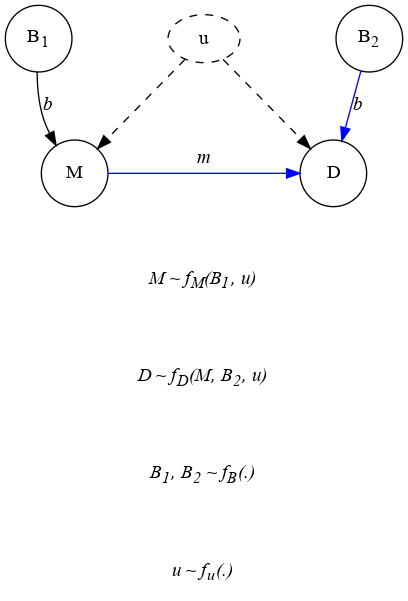

In [14]:
# Display Causal Diagram
file_path = "/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Graphviz_functions/causal_diagram.png"
img = Image.open(file_path)
display(img)

<div style="font-size:12pt; font-weight:bold;">Create Synthetic Data</div>

In [10]:
%%julia
#   Generating Data
    sim_data = generate_synthetic_data()

#   Moving Into a DataFrame for Export to Dataplot
    sim_df = DataFrame(U = sim_data["U"], M = sim_data["M"], B2 = sim_data["B2"], 
                        B1 = sim_data["B1"], D = sim_data["D"])

#   Looking at Data
    println(summarize_df(sim_df, n=5, num_cols=6));

200×5 DataFrame
 Row  U          M          B2     B1     D
      Float64    Float64    Int64  Int64  Float64
────────────────────────────────────────────────────
 1    -1.26301   0.551022   0      1      -0.887439
 2    1.10342    5.0479     0      1      1.64358
 3    0.0918798  -0.988813  1      0      0.662284
 4    0.564019   1.28469    0      0      0.63536
 5    0.556318   0.235488   0      0      0.280672

 196  -0.713484  0.0196384  1      0      2.22689
 197  0.428668   1.32319    0      0      0.219888
 198  -1.97108   -0.19717   0      1      -0.843911
 199  0.926256   1.56749    0      0      1.56937
 200  -0.268078  1.27341    0      1      1.75503nothing

In [11]:
%%julia
#   Exporting to Dataplot for some Initial Descriptive Analyses
    cd("Dataplot_functions")
    dataplot_export(sim_df, "two_moms")
    cd("../")

In [12]:
%%julia
#   Exporting to R to Specify a Probabilistic Model
    cd("R_functions")
    R_export(sim_data, pwd(), "two_moms", "two_moms")
    cd("../")

<div style="font-size:12pt; font-weight:bold;">Descriptive Analyses</div>

In [15]:
# Change Directory to Dataplot_functions
os.chdir('/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Dataplot_functions')

# Start a NIST Dataplot session
dp = pexpect.spawn("dataplot")

In [16]:
dp.sendline("CALL Two_Moms_4Plot.DP")  # Define a variable
dp.expect(r">")

0

In [18]:
dp.sendline("SUMMARY D")  # Define a variable
dp.expect(r">")
print(dp.before.decode())


SUMMARY D
  
             Summary of        200 Observations
  
 Response Variable: D
  
  
 --------------------------------------------------------------------------
          Location Measures           |         Dispersion Measures
 --------------------------------------------------------------------------
             Midrange:         0.7072 |               Range:        10.4263
                 Mean:         0.7742 |  Standard Deviation:         1.6782
              Midmean:         0.7786 |   Average Abs. Dev.:         1.2758
               Median:         0.7532 |             Minimum:        -4.5060
                                      |      Lower Quartile:        -0.2557
                                      |         Lower Hinge:        -0.2546
                                      |         Upper Hinge:         1.8008
                                      |      Upper Quartile:         1.8093
                                      |             Maximum:         5.9204
 --

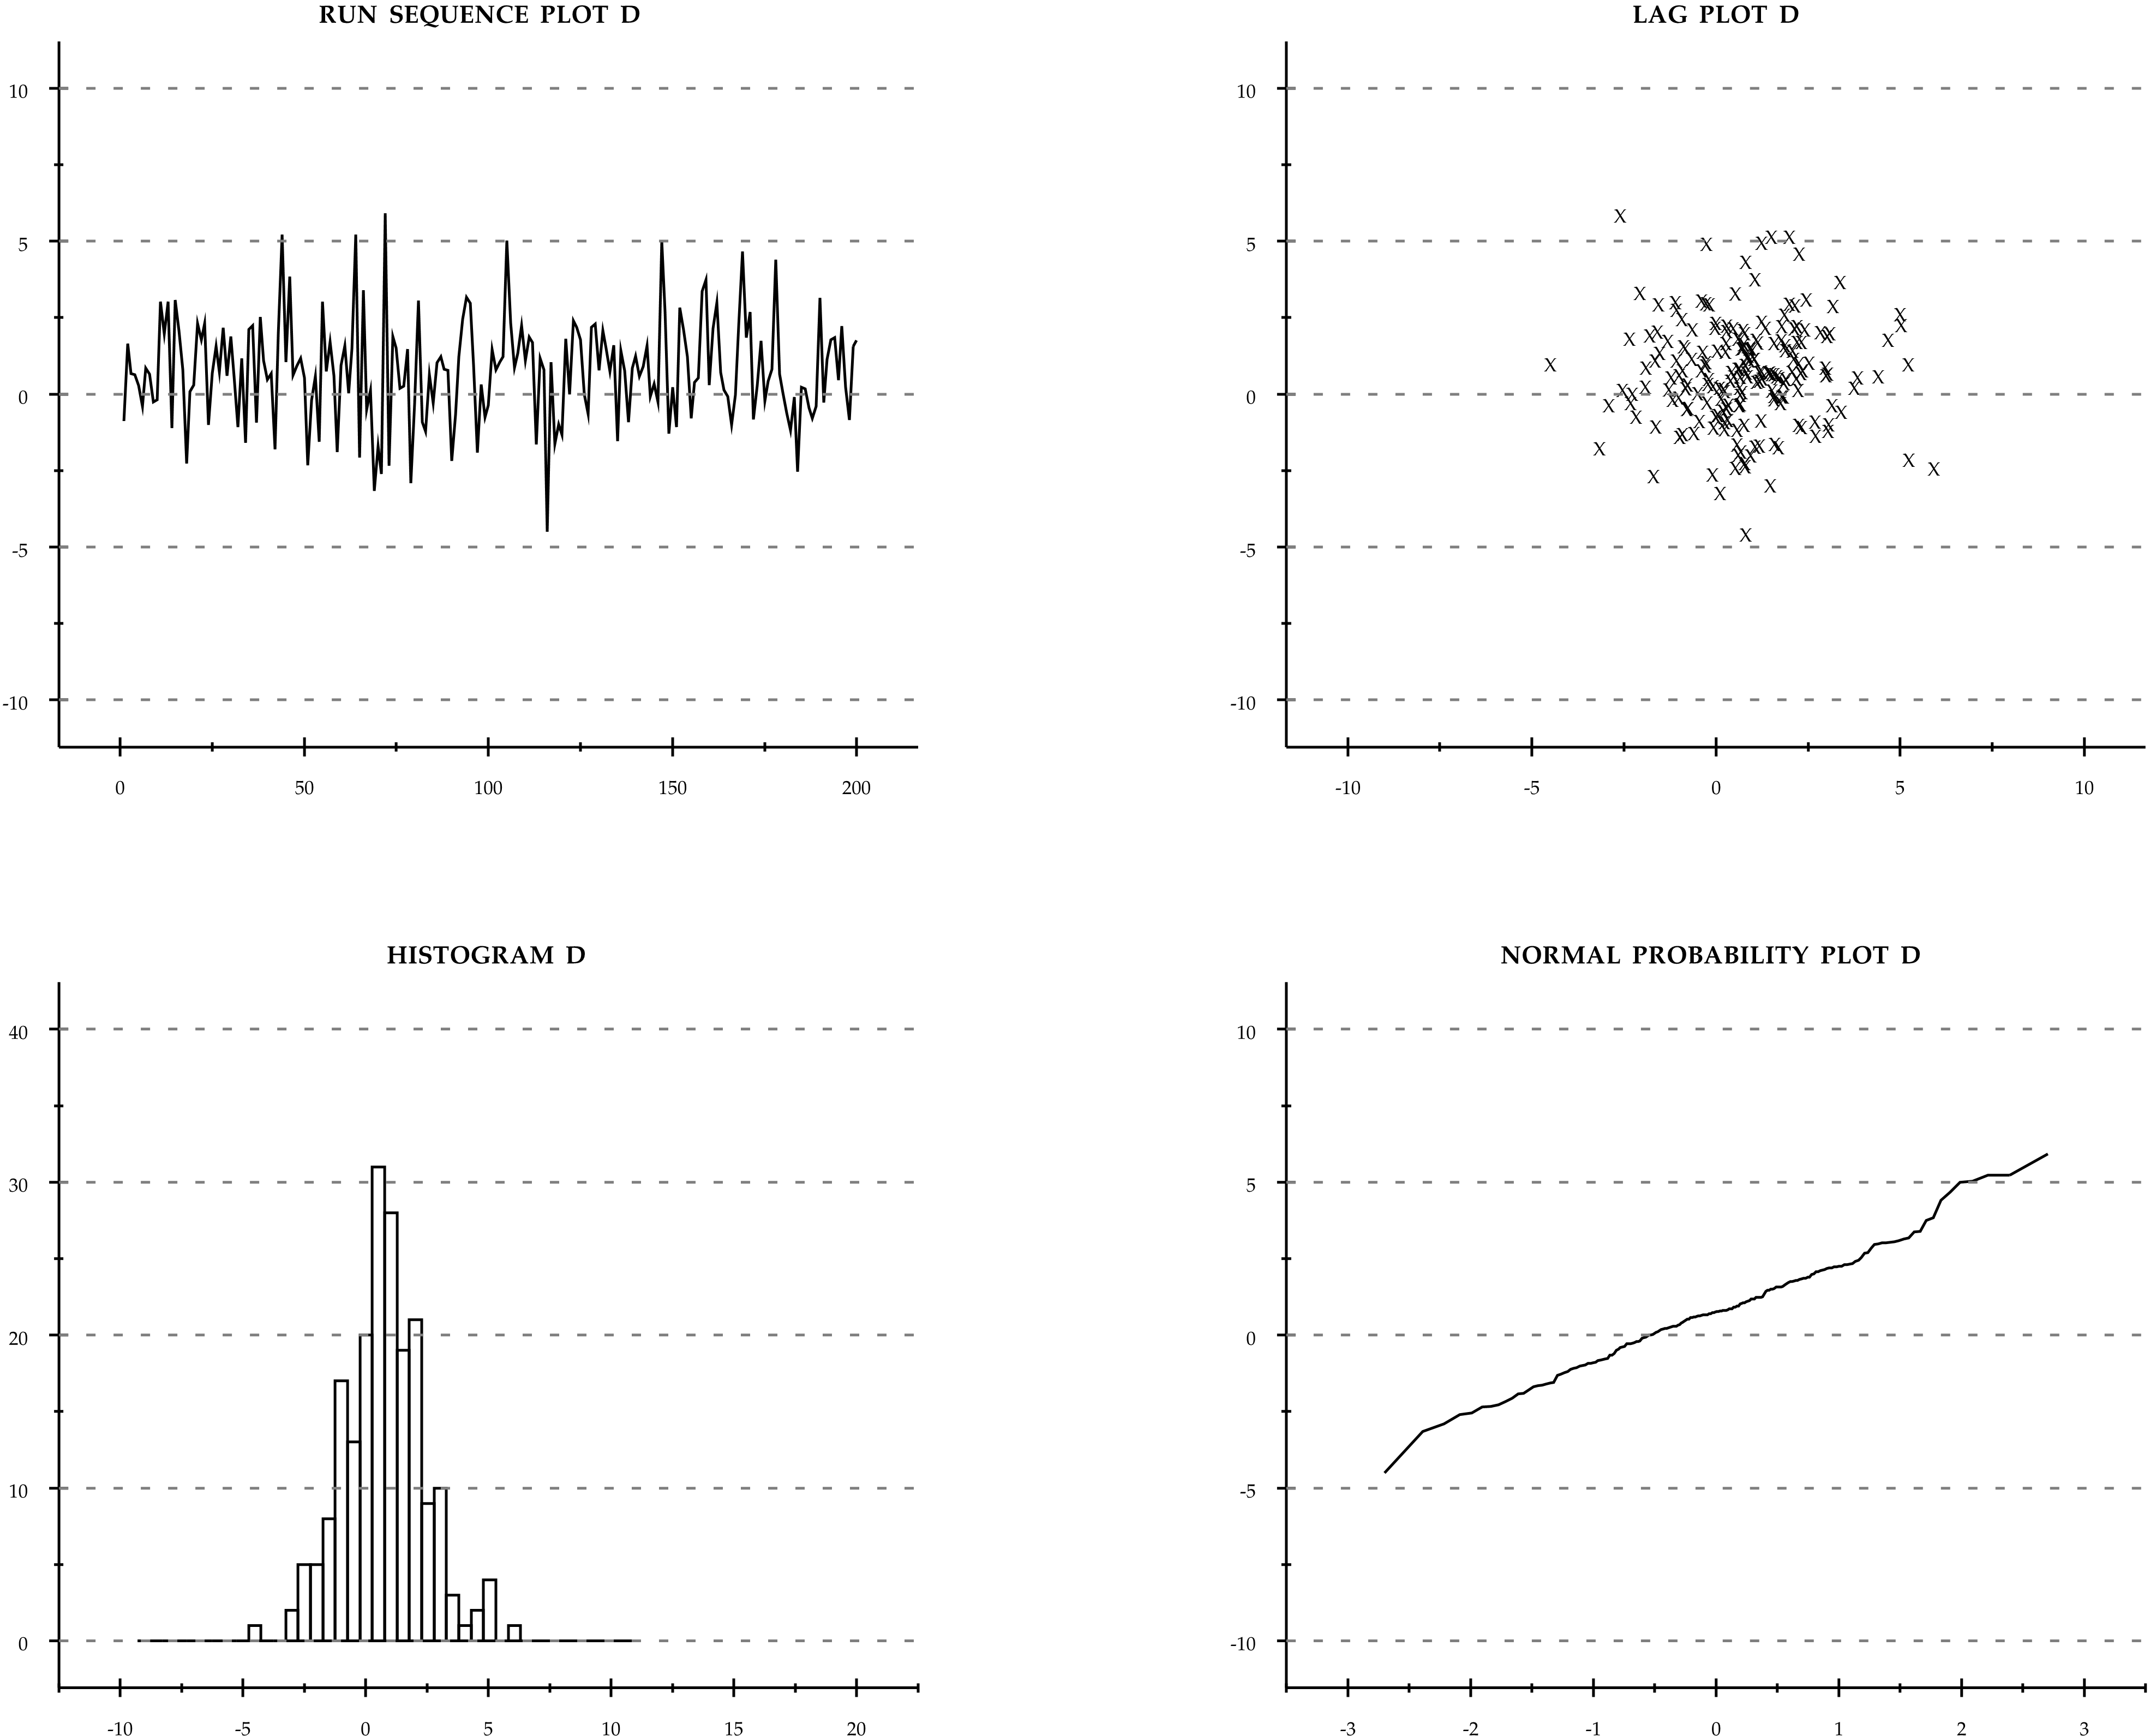

In [19]:
# Examine 4-Plot to Check if Daughters' Family Size Has Unaccounted for Structure
file_path = "/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Analyses/Figures/Two_Moms_4Plot.png"
img = Image.open(file_path)
display(img)

In [20]:
dp.sendline("LOWESS_Scatter.DP")  # Define a variable
dp.expect(r">")

0

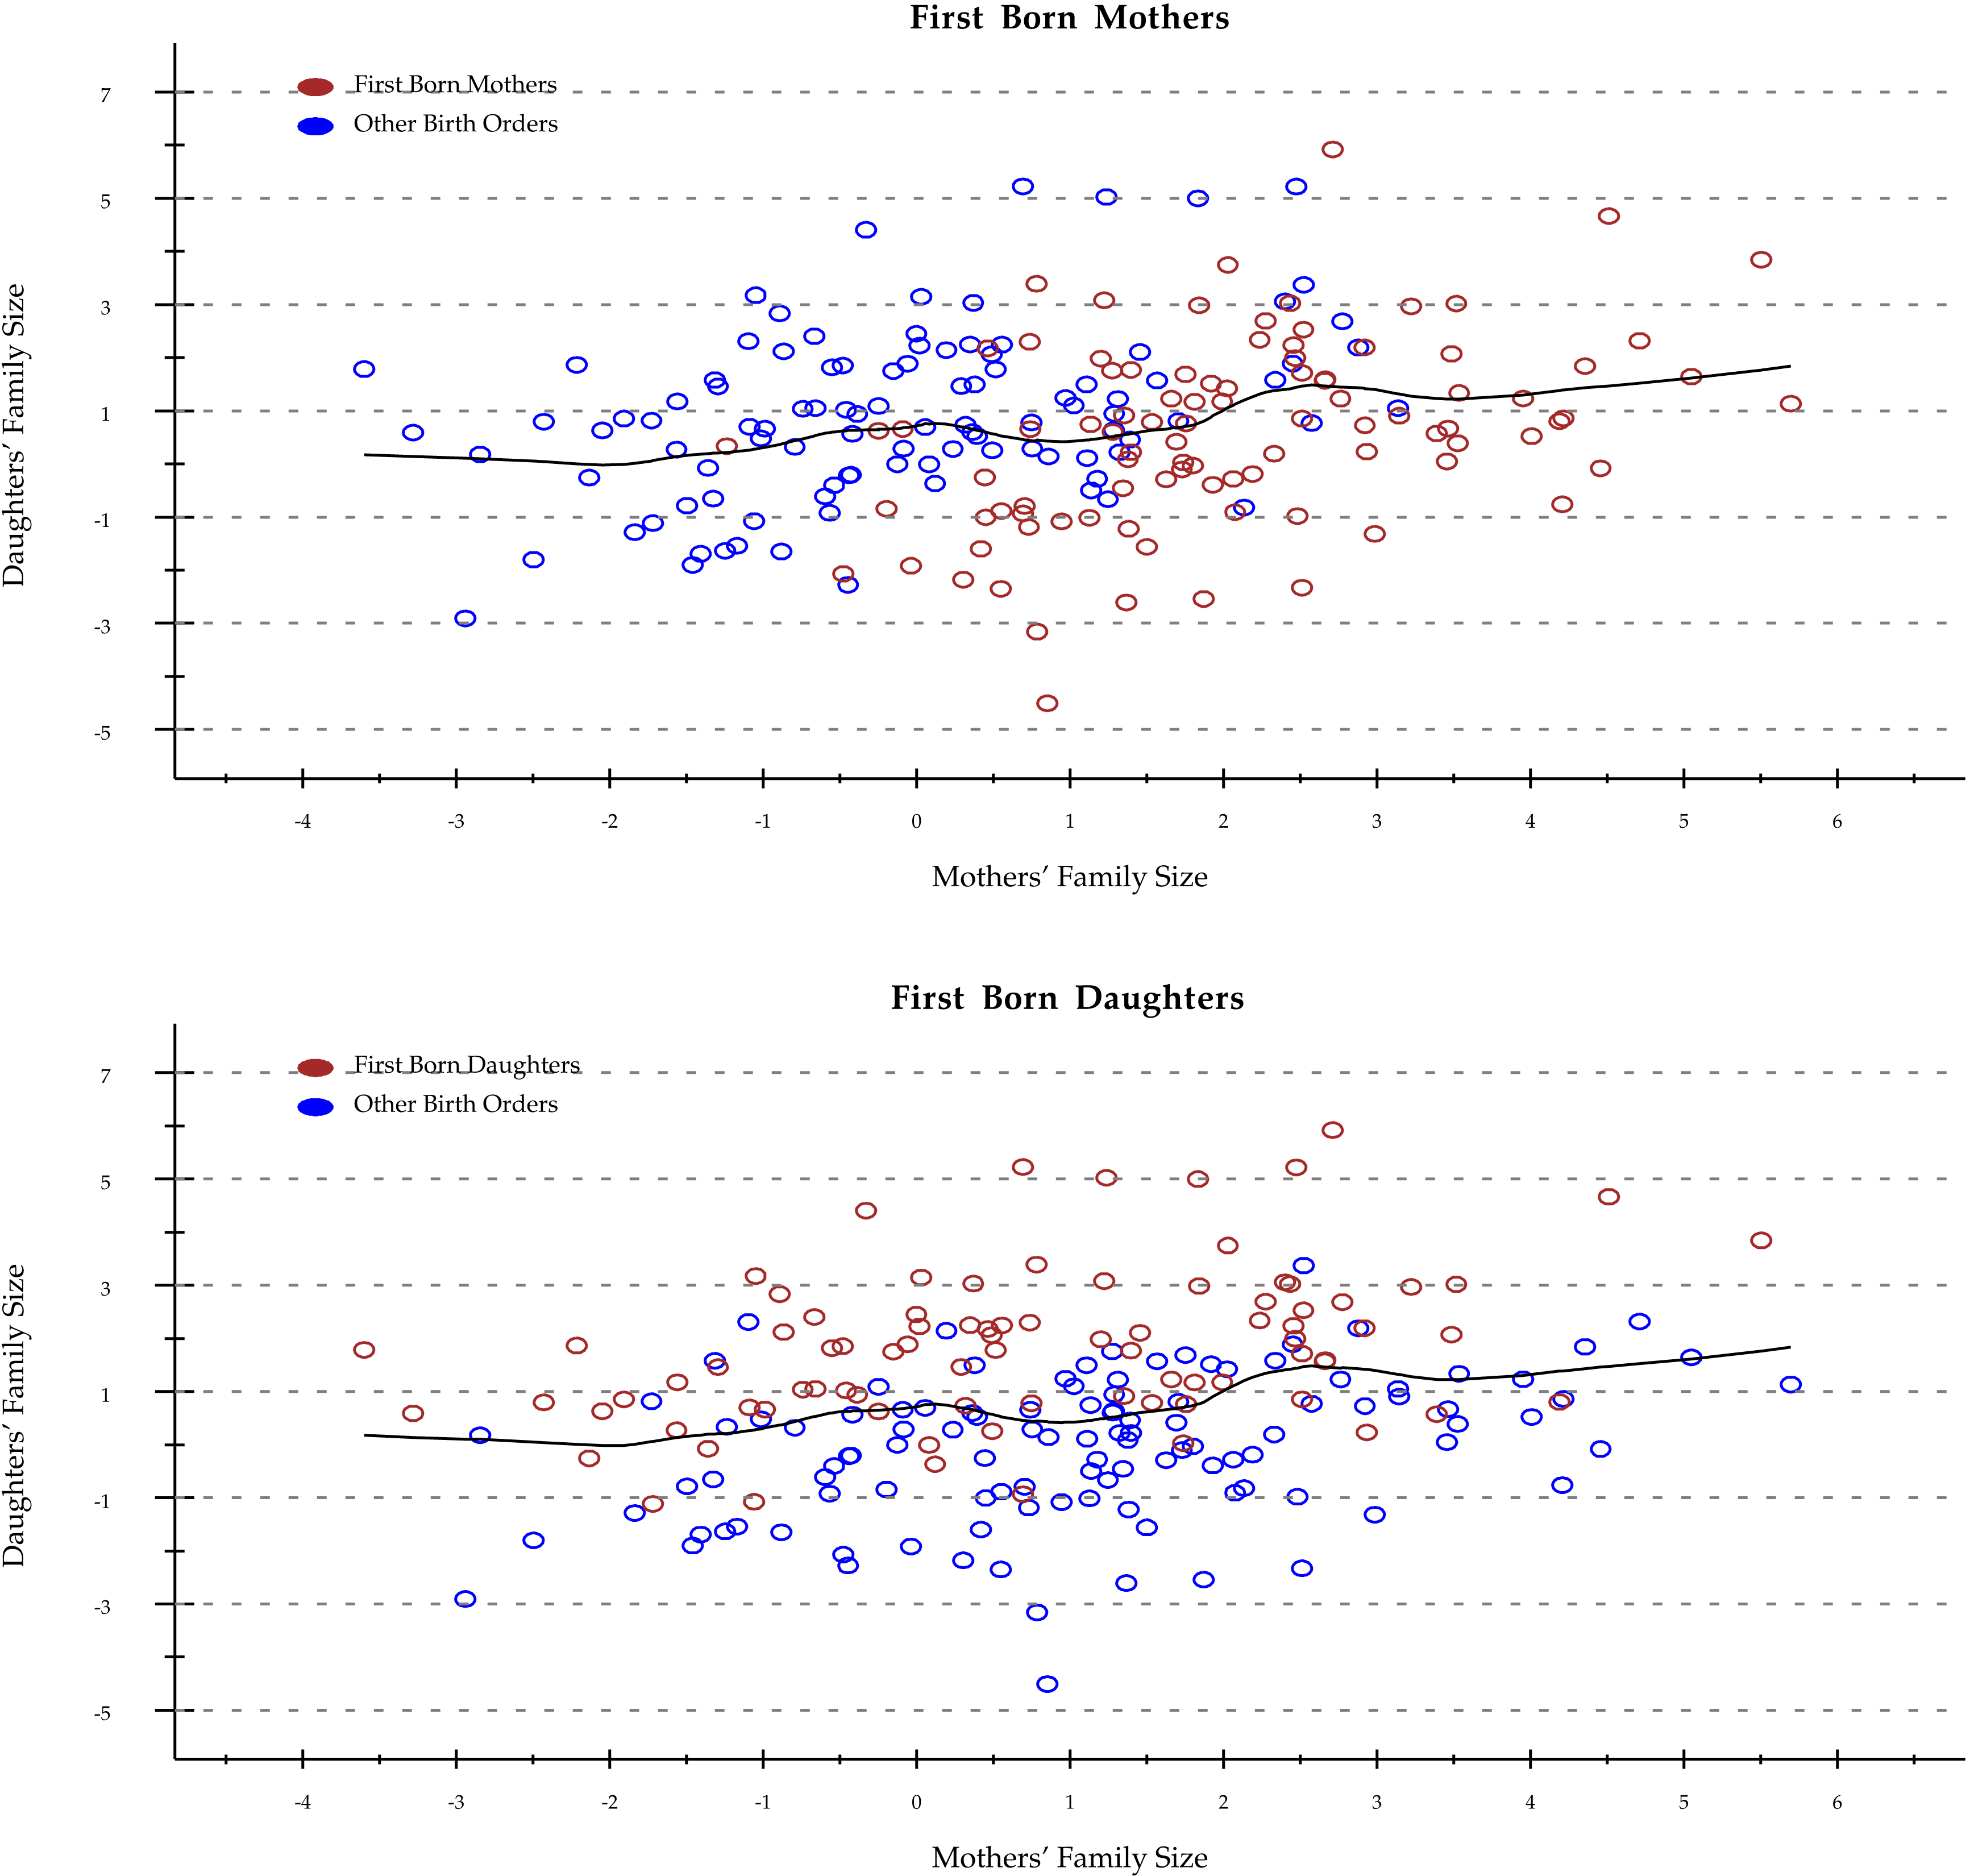

In [21]:
# Examining the Relationship between Mothers' Family Size & Daughters with Respect to Birth Order
file_path = "/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Analyses/Figures/Two_Moms_LOWESS_Scatter.png"
img = Image.open(file_path)
display(img)

In [22]:
# Exiting Dataplot for Now
dp.sendline("exit")  
dp.expect(r">")

0

<div style="font-size:12pt; font-weight:bold;">Specifying & Estimating the Model</div>

In [23]:
%%R
#   Setting Working Directory
    setwd("/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Stan_models")

#   Compiling Model
    mod <- cmdstanr::cmdstan_model("Two_Moms_MultivariateNormal.stan")
  
#   Checking Model
    mod$print()

//Two Moms Model with Prior, Posterior, Likelihood, & MAP Estimates Included
//Implementing McElreath's Multivariate Normal Distribution Specification
//Included Cholesky Factorization to Handle the Multi-Collinearity Issues Causing Poor Posterior Exploration
//Jonathan H. Morgan, Ph.D.
//22 January 2025

data {
    int<lower=1> N;                   // Number of observations
    array[N] int<lower=0, upper=1> B1; // First sibling's birth order (binary)
    array[N] int<lower=0, upper=1> B2; // Second sibling's birth order (binary)
    vector[N] M;                      // Family sizes (Mom model)
    array[N] real D;                  // Outcome variable (Daughter model)
}

parameters {
    real a1;                          // Intercept for Mom model
    real a2;                          // Intercept for Daughter model
    real b;                           // Effect of Birth Order, B1 and B2
    real m;                           // Effect of M on D
    real<lower=0> sigma_M;            /

Model executable is up to date!


<div style="font-size:10pt; font-weight:bold;">Analytic Strategy</div>
<div style="font-size:10pt;">McElreath jointly models 𝑀 (Mothers' family size) and 𝐷 (Daughters' family size) as arising from a multivariate normal distribution. This approach allows him to account for the influence of an unmeasured variable 𝑈 that may simultaneously affect both 𝑀 and 𝐷. While 𝑈 is not explicitly included in the model, its effects are captured indirectly through the covariance structure of the multivariate normal. Specifically, the off-diagonal elements of the covariance matrix (Σ) represent the shared variability between 𝑀 and 𝐷 that could be attributed to 𝑈, such as socio-economic status,  cultural factors, or genetic influences in the Two Moms' example. By modeling 𝑀 and 𝐷 jointly, he isolates the direct effect of 𝑀 on 𝐷 (quantified by the parameter 𝑚) from this shared variability, reducing the risk of confounding. Additionally, this approach respects the fact that 𝑀 and 𝐷 are not independent and improves the robustness of the estimates for 𝑚 while still accounting for other covariates like birth order (𝐵1and 𝐵2). Here, I use Cholesky decomposition to address the high multicollineary between the covariates that otherwise results in poor sampling, reflected in low E-BFMI scores.</div>

In [26]:
%%R
#   Set Working Directory
    setwd("/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/R_functions")

#   Load Data
    load("two_moms.Rda")

#   Setting Temporary Directory
    temp <- tempdir()

In [27]:
%%R
#   Specifying Input Data Objects
    data <- list(N = length(two_moms$M), B1 = two_moms$B1, B2 = two_moms$B2, 
                 M = two_moms$M, D = two_moms$D)

#   Saving Input Data
    save(data, file='Two_Moms_Input_Data.Rdata')

In [28]:
%%R
# Fitting the Model
  fit <- mod$sample(
    data = data,
    output_dir = temp,
    seed = 123,
    chains = 4,
    thin = 1,
    parallel_chains = 4,
    iter_warmup = 2000,
    iter_sampling = 2000,
    adapt_delta = 0.99,
    max_treedepth = 15,
    refresh = 500
  )
    
  # Checking that the Model Passes: E-BFMI, Treedepth, Sample Size, & R-Hat Cursory Checks
    fit$cmdstan_diagnose()  

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 4000 [  0%]  (Warmup) 
Chain 2 Iteration:    1 / 4000 [  0%]  (Warmup) 
Chain 3 Iteration:    1 / 4000 [  0%]  (Warmup) 
Chain 4 Iteration:    1 / 4000 [  0%]  (Warmup) 
Chain 4 Iteration:  500 / 4000 [ 12%]  (Warmup) 
Chain 2 Iteration:  500 / 4000 [ 12%]  (Warmup) 
Chain 3 Iteration:  500 / 4000 [ 12%]  (Warmup) 
Chain 1 Iteration:  500 / 4000 [ 12%]  (Warmup) 
Chain 4 Iteration: 1000 / 4000 [ 25%]  (Warmup) 
Chain 2 Iteration: 1000 / 4000 [ 25%]  (Warmup) 
Chain 3 Iteration: 1000 / 4000 [ 25%]  (Warmup) 
Chain 1 Iteration: 1000 / 4000 [ 25%]  (Warmup) 
Chain 2 Iteration: 1500 / 4000 [ 37%]  (Warmup) 
Chain 4 Iteration: 1500 / 4000 [ 37%]  (Warmup) 
Chain 3 Iteration: 1500 / 4000 [ 37%]  (Warmup) 
Chain 1 Iteration: 1500 / 4000 [ 37%]  (Warmup) 
Chain 4 Iteration: 2000 / 4000 [ 50%]  (Warmup) 
Chain 4 Iteration: 2001 / 4000 [ 50%]  (Sampling) 
Chain 2 Iteration: 2000 / 4000 [ 50%]  (Warmup) 
Chain 2 Iteration: 2001 / 4

In [ ]:
%%R
#   Getting Posterior Draws
    draws_array <- fit$draws()
    str(draws_array)
    
#   Converting to data frame 
    draws_df <- as_draws_df(draws_array)
    draws_df <- as.data.frame(draws_df)

#   Saving Draws Data
    save(draws_df, file='Two_Moms_Data_Draws.Rdata')

 'draws_array' num [1:2000, 1:4, 1:3017] -599 -596 -596 -595 -596 ...
 - attr(*, "dimnames")=List of 3
  ..$ iteration: chr [1:2000] "1" "2" "3" "4" ...
  ..$ chain    : chr [1:4] "1" "2" "3" "4"
  ..$ variable : chr [1:3017] "lp__" "a1" "a2" "b" ...


In [29]:
%%R
#   Creating Fit Objects
    sfit <- fit$output_files() %>%
      rstan::read_stan_csv()
    
#   Creating Summary Object
    rstan_summary <- rstan::summary(sfit)
    rstan_summary <- rstan_summary$summary
    rstan_summary <- as.data.frame(rstan_summary)

#   Saving Summary Data
    save(rstan_summary, file='Two_Moms_Data_Summary.Rdata')

In [11]:
%%R
#   Creating Diagnostics Object
    diagnostics_df <- as_draws_df(fit$sampler_diagnostics())
    diagnostics_df <- as.data.frame(diagnostics_df)

#   Saving Diagnostic Data
    save(diagnostics_df, file='Two_Moms_Data_Diagnostics.Rdata')

In [13]:
%%R
# Isolating Prior Predictive Distributions for Mothers' Family Sizes & Daughters' Family Sizes
  m_prior_pred <- as.data.frame(sfit, pars = "prior_M")
  d_prior_pred <- as.data.frame(sfit, pars = "prior_D")

# Saving Posterior Predictive Distributions
  save(m_prior_pred, file='Two_Moms_Mother_PriorPred.Rdata') 
  save(d_prior_pred, file='Two_Moms_Daughter_PriorPred.Rdata') 

In [30]:
%%R
# Isolating Posterior Predictive Distributions for Mothers' Family Sizes & Daughters' Family Sizes
  m_post_pred <- as.data.frame(sfit, pars = "posterior_M")
  d_post_pred <- as.data.frame(sfit, pars = "posterior_D")
  d_map <- as.data.frame(sfit, pars = "y")

# Saving Posterior Predictive Distributions
  save(m_post_pred, file='Two_Moms_Mother_PostPred.Rdata') 
  save(d_post_pred, file='Two_Moms_Daughter_PostPred.Rdata') 
  save(d_map, file='Two_Moms_Daughter_MAP.Rdata')

In [24]:
%%R
# Analyzed Variables
  alpha_posteriors <- row.names(rstan_summary)[grepl("a", row.names(rstan_summary))]
  beta_posteriors <- row.names(rstan_summary)[grepl("b", row.names(rstan_summary))]
  m_posterior <-  row.names(rstan_summary)[grepl("m", row.names(rstan_summary))]
  variables <- c(alpha_posteriors, beta_posteriors, m_posterior)
  chain_values <- matrix(c(1, 2001, 4001, 6001, 2000, 4000, 6000, 8000),ncol=2, nrow=4)
    
# Creating Posterior List
  posterior_list <- vector('list', length(variables))
  names(posterior_list) <- variables
  for (i in seq_along(posterior_list)) {
    posterior_list[[i]] <- vector('list', 4)
  }
    
  for (i in seq_along(variables)) {
    var_draws <- draws_df[ ,c(variables[[i]])]
    for (j in seq_along(posterior_list[[i]])){
      iteration_values <- chain_values[j, ]
      posterior_list[[i]][[j]] <- var_draws[c(iteration_values[[1]]:iteration_values[[2]])]
      rm(iteration_values)
    }
    rm(var_draws)
  }

# Saving Posterior List
  save(posterior_list, file='Two_Moms_PosteriorList.Rdata')  

<div style="font-size:12pt; font-weight:bold;">Convergence Checks</div>

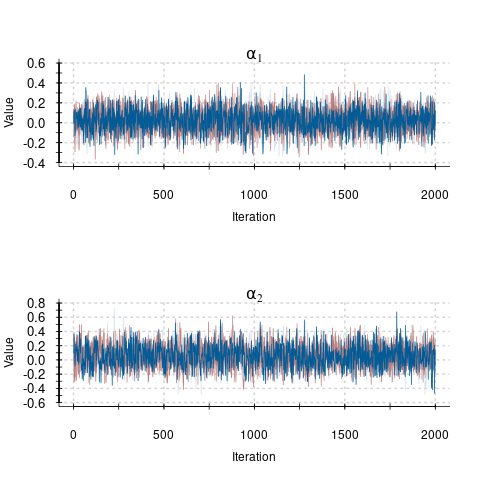

In [ ]:
%%R  
#   Evaluating Mothers' (a1) and Daughters' (a2) Intercepts
    par(family = "Palatino Linotype")
    layout.matrix <- matrix(c(1,2), nrow = 2, ncol = 1)
    layout(mat = layout.matrix) # Widths of the two columns
    layout.show(n=2)
    
    plot_list <- posterior_list[c(1:2)]
    plot_names <- c('alpha[1]', 'alpha[2]')
    for (i in seq_along(plot_list)){
      chains_visualization(plot_names[[i]], plot_list[[i]])
    }

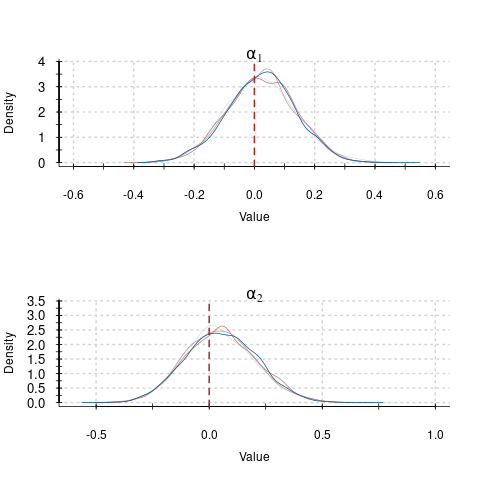

In [ ]:
%%R
#   Evaluating Mothers' (a1) and Daughters' (a2) Intercepts
    par(family = "Palatino Linotype")
    layout.matrix <- matrix(c(1,2), nrow = 2, ncol = 1)
    layout(mat = layout.matrix) # Widths of the two columns
    layout.show(n=2)

#   Looking at Intercept Posteriors for Mothers' & Daughters'
    for (i in seq_along(plot_list)){
      density_visualization(plot_names[[i]], plot_list[[i]])
    }

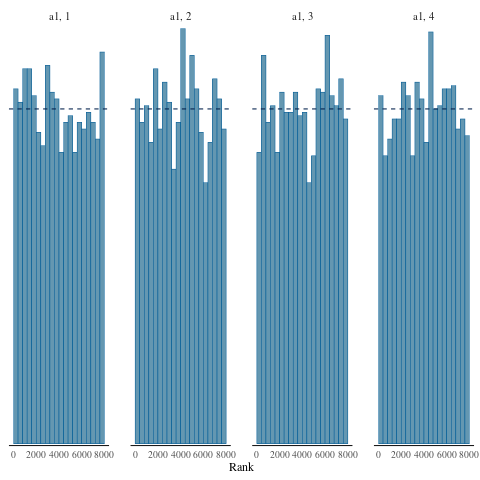

In [41]:
%%R
#   Look at how the ranking of MCMC samples mixed between chains for Mothers' intercept.
    mcmc_rank_hist(draws_array, "a1", ref_line = TRUE)

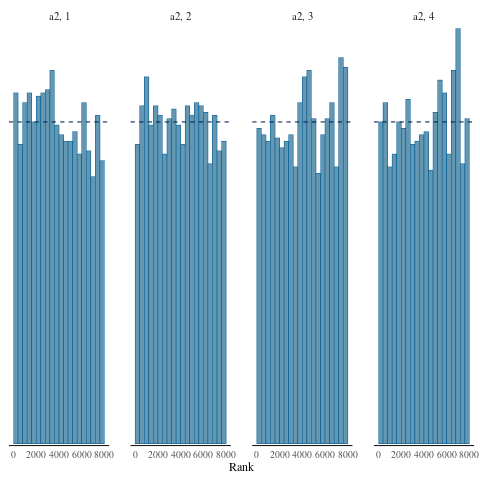

In [42]:
%%R
#   Look at how the ranking of MCMC samples mixed between chains for Daughters' intercept.
    mcmc_rank_hist(draws_array, "a2", ref_line = TRUE)

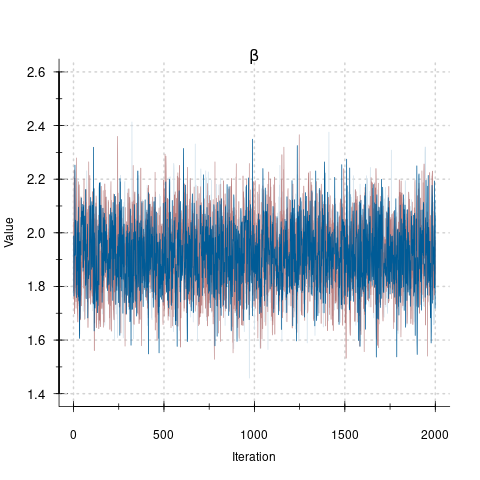

In [ ]:
%%R  
#   Evaluating the Effect of Birth Order: The Model Assumes the Same Effect for Both Mothers & Daughters.
    par(family = "Palatino Linotype")
    layout.matrix <- matrix(c(1), nrow = 1, ncol = 1)
    layout(mat = layout.matrix) # Widths of the two columns
    layout.show(n=2)
    
    plot_list <- posterior_list[c(10)]
    plot_names <- c('beta')
    for (i in seq_along(plot_list)){
      chains_visualization(plot_names[[i]], plot_list[[i]])
    }

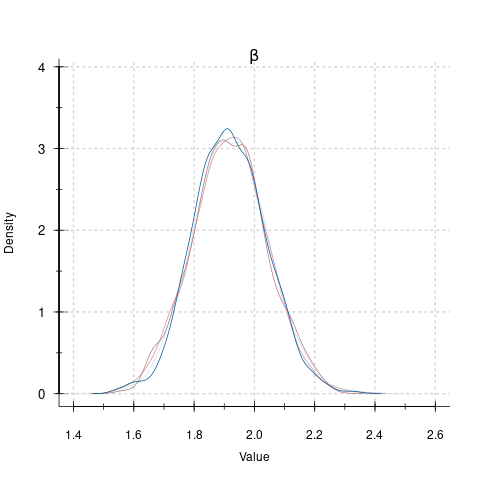

In [26]:
%%R  
#   Evaluating the Effect of Birth Order 
    par(family = "Palatino Linotype")
    layout.matrix <- matrix(c(1), nrow = 1, ncol = 1)
    layout(mat = layout.matrix) # Widths of the two columns
    layout.show(n=2)
    
    plot_list <- posterior_list[c(10)]
    plot_names <- c('beta')
    for (i in seq_along(plot_list)){
      density_visualization(plot_names[[i]], plot_list[[i]])
    }

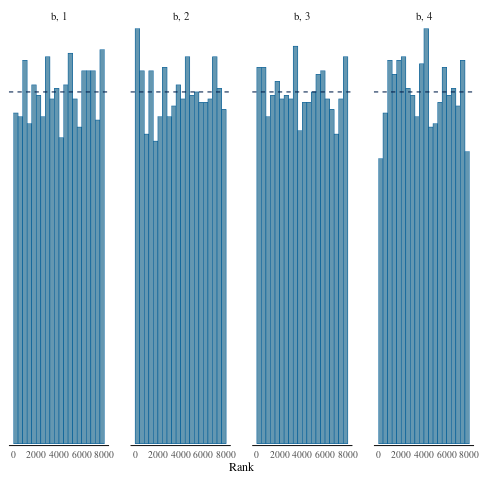

In [43]:
%%R
#   Look at how the ranking of MCMC samples mixed between chains for Birth Order.
    mcmc_rank_hist(draws_array, "b", ref_line = TRUE)

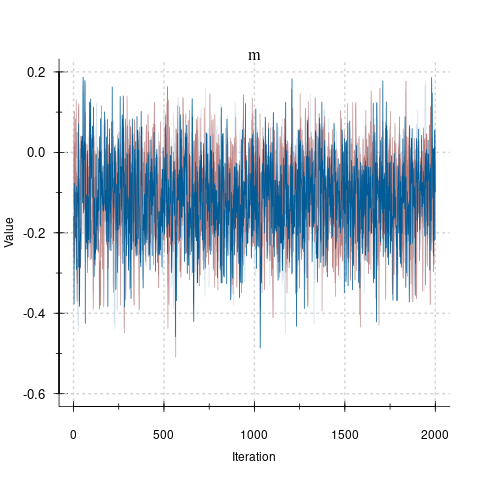

In [24]:
%%R  
#   Evaluating the Effect of Mothers' Family Size on Daughters' Family Size
    par(family = "Palatino Linotype")
    layout.matrix <- matrix(c(1), nrow = 1, ncol = 1)
    layout(mat = layout.matrix) # Widths of the two columns
    layout.show(n=2)
    
    plot_list <- posterior_list[c(11)]
    plot_names <- c('m')
    for (i in seq_along(plot_list)){
      chains_visualization(plot_names[[i]], plot_list[[i]])
    }

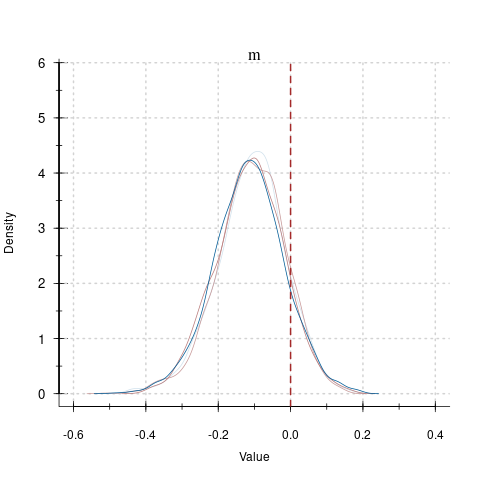

In [23]:
%%R  
#   Evaluating the Effect of Birth Order 
    load("Two_Moms_PosteriorList.Rdata")
    layout.matrix <- matrix(c(1), nrow = 1, ncol = 1)
    layout(mat = layout.matrix) # Widths of the two columns
    layout.show(n=2)
    
    par(family = "Palatino Linotype")
    plot_list <- posterior_list[c(11)]
    plot_names <- c('m')
    for (i in seq_along(plot_list)){
      density_visualization(plot_names[[i]], plot_list[[i]])
    }

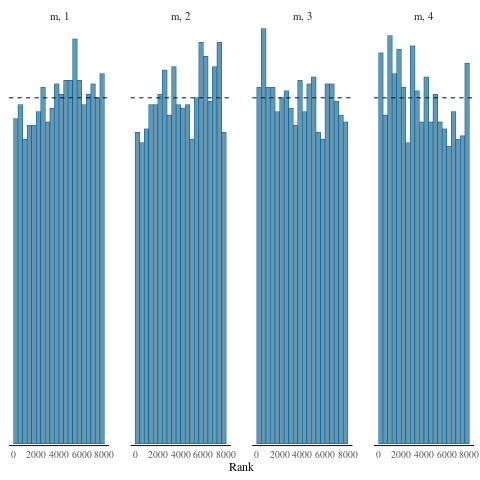

In [44]:
%%R
#   Look at how the ranking of MCMC samples mixed between chains for Mother's Family Size.
    mcmc_rank_hist(draws_array, "m", ref_line = TRUE)

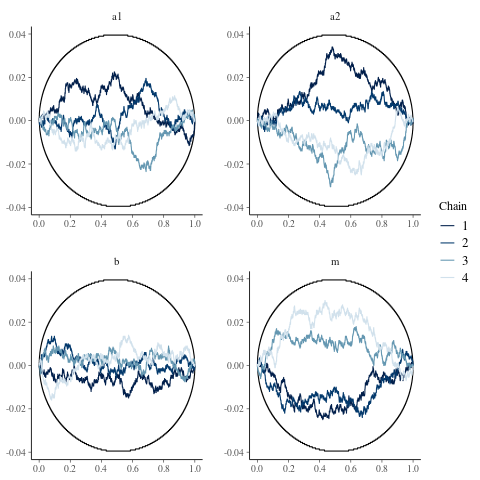

In [ ]:
%%R
# Plotting the ranking of MCMC samples between chains.
# Provide 99% simultaneous confidence intervals for the chains sampling from the same distribution.
  mcmc_rank_ecdf(draws_array, c("a1", "a2", "b", "m"), prob = 0.99, plot_diff = TRUE)

<div style="font-size:12pt; font-weight:bold;">Prior Prdictive Checks</div>

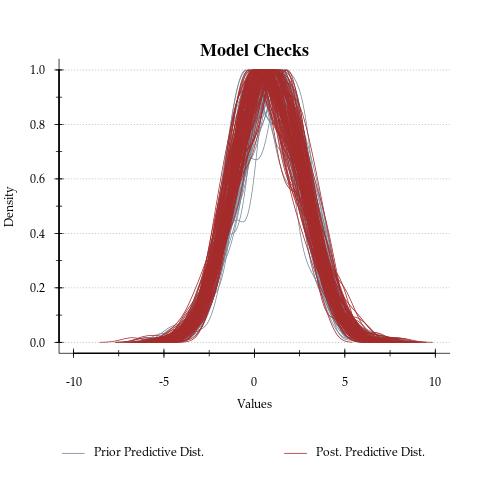

In [16]:
%%R
#   Loading Data
    load("Two_Moms_Data_Draws.Rdata")

#   Comparing teh Prior Predictive Distribution with the Posterior Predictive Distributions & Daughter's Family Size
    par(family = "Palatino Linotype")
    shrinkage_plot <- shrinkage_check(draws_df, data$D,"prior_D",  "posterior_D", 100)

#   Not Much Learning in this Model

<div style="font-size:12pt; font-weight:bold;">Model Evaluation: PSIS-LOO & Simulation Comparisons</div>

In [17]:
%%R
#   Extracting the Log Likelihood Estimates
    log_lik <- as.matrix(draws_df[, grepl("log_lik", colnames(draws_df))])
    
#   Calculating the Relative Effect: MCMC effective sample size/total sample size
    r_eff <- loo::relative_eff(exp(log_lik), chain_id = rep(1:4, each = 2000))
    
#   Creating Weights: Assuming Equal Weights
    weights <- rep(1, nrow(log_lik))
    
#   Performing LOO Cross-Validation: 14.6% of the sample has a Pareto K above 0.7
    loo_result <- loo(log_lik, r_eff = r_eff, weights = weights)
    print(loo_result)


Computed from 8000 by 200 log-likelihood matrix.

         Estimate   SE
elpd_loo   -954.9 14.7
p_loo         7.6  0.7
looic      1909.9 29.3
------
MCSE of elpd_loo is 0.0.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.4, 1.3]).

All Pareto k estimates are good (k < 0.7).
See help('pareto-k-diagnostic') for details.


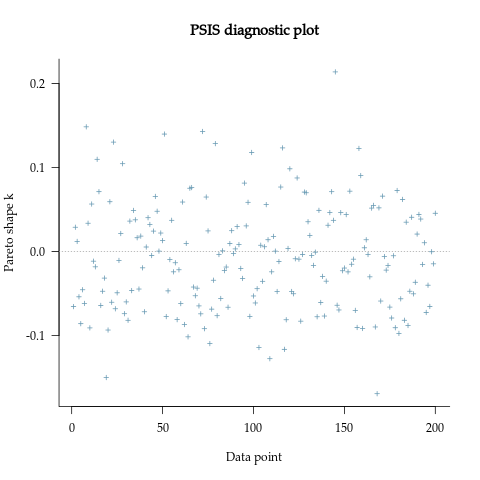

In [18]:
%%R
#   Plotting Loo Results
    par(family = "Palatino Linotype")
    plot(loo_result, label_points = TRUE)

<div style="font-size:10pt; font-weight:bold;">The Actual Value of b in the Simulation: 2</div>
<div style="font-size:10pt;">2 is within the HDPI of the Estimate</div>

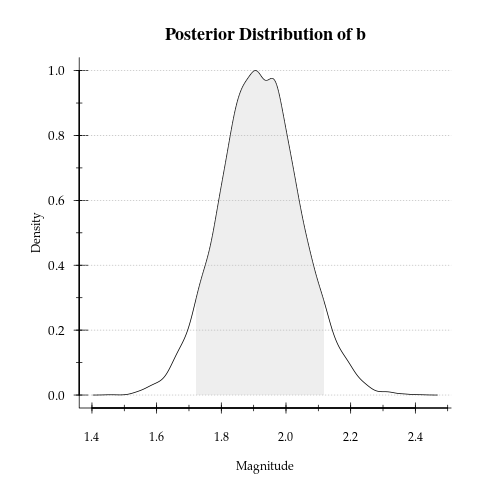

In [35]:
%%R
#   Extract m values
    b_values <- draws_df[, grepl("b", colnames(draws_df))]  
    b_list <- list(b_values = b_values)

#   Plotting the Posterior Distribution with HDPI of b
    par(family = "Palatino Linotype")
    b_posterior <- posterior_plot(b_list, "Posterior Distribution of b", "Magnitude", 0.11)

<div style="font-size:10pt; font-weight:bold;">The Actual Value of m in the Simulation: 0</div>
<div style="font-size:10pt;">0 is within the HDPI of the Estimate</div>

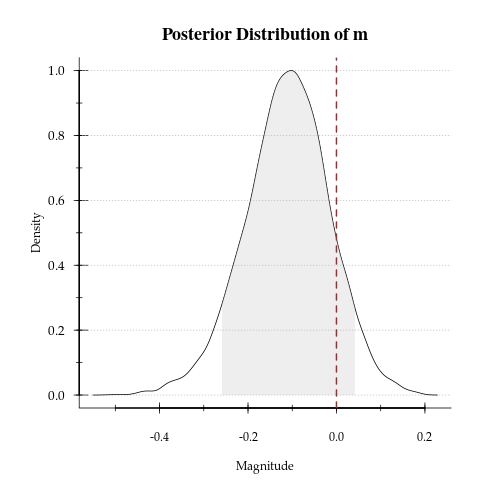

In [37]:
%%R
#   Extract m values
    m_values <- draws_df[, grepl("m", colnames(draws_df))]$m  
    m_list <- list(m_values = m_values)

#   Plotting the Posterior Distribution with HDPI of m
    par(family = "Palatino Linotype")
    m_posterior <- posterior_plot(m_list, "Posterior Distribution of m", "Magnitude", 0.11)

<div style="font-size:12pt; font-weight:bold;">Estimating Bayes Factor Against the Null</div>

<div style="font-size:10pt; font-weight:bold;">Null Model Causal Model</div>

In [40]:
%%bash
cd /mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Graphviz_functions && \
dot -Tpng Two_Moms_NullModel.gv -o null_diagram.png

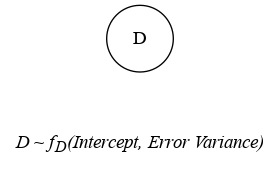

In [41]:
# Display Causal Diagram
file_path = "/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Graphviz_functions/null_diagram.png"
img = Image.open(file_path)
display(img)

In [25]:
%%R
#   Setting Working Directory
    setwd("/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Stan_models")

#   Compiling Model
    null_mod <- cmdstanr::cmdstan_model("Two_Moms_Null.stan")
  
#   Checking Model
    null_mod$print()

// Assessing Evidence for the Null Hypothesis:
// Namely, that Daughter Family Size (D) is only a function of the population-level posterior mean (i.e., the intercept),
// with no influence from covariates (e.g., B1, B2, or M).
//Jonathan H. Morgan, Ph.D.
//23 January 2025

data {
    int<lower=1> N;                   // Number of observations
    vector[N] M;                      // Family sizes (Mom model)
    array[N] real D;                  // Outcome variable (Daughter model)
}

parameters {
    real a2;                          // Intercept for Daughter model
    real<lower=0> sigma_D;            // Standard deviation for Daughter model
}

transformed parameters {
    vector[N] mu_D;                   // Daughter model linear predictor

    // Linear predictor (intercept only, no covariate effects)
    mu_D = rep_vector(a2, N);
}

model {
    // Priors
    a2 ~ normal(0, 0.5);
    sigma_D ~ exponential(1);

    // Likelihood for Daughter model
    D ~ normal(mu_D, sigma_D);
}

g

Model executable is up to date!


In [6]:
%%R
#   Set Working Directory
    setwd("/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/R_functions")

#   Loading Data File
    load("Two_Moms_Input_Data.Rdata")

#   Setting Model Path
    file_path <- "/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Stan_models/Two_Moms_Null.stan"

#   Fitting the Model
    null_fit <- rstan::stan(
        file = file_path,                  # Path to the Stan model file
        data = data,                       # Data to pass to the model
        chains = 4,                        # Number of MCMC chains
        thin = 1,                          # Thinning interval
        iter = 4000,                       # Total number of iterations (warmup + sampling)
        warmup = 2000,                     # Number of warmup iterations
        seed = 123,                        # Random seed for reproducibility
        cores = 4,                         # Number of cores for parallelization
        control = list(
            adapt_delta = 0.99,            # Target acceptance rate
            max_treedepth = 15             # Maximum tree depth for NUTS
        ),
        refresh = 500                      # Interval to print progress
    )

In [7]:
%%R 
# Fitting Candidate Model as a RStan Model for the Purpose of Calculating the Bayes Factor
# CmdStan for General Modeling Has Better Diagnostics, Is Faster, Always Up to Date, and More Flexible. 
# But, bridgesampling expects RStan Fit Objects, and is sensitive to conversions from CmdStan to RStan

#   Setting Model Path
    file_path <- "/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Stan_models/Two_Moms_MultivariateNormal.stan"

#   Fitting the Model
    candidate_fit <- rstan::stan(
        file = file_path,                  # Path to the Stan model file
        data = data,                       # Data to pass to the model
        chains = 4,                        # Number of MCMC chains
        thin = 1,                          # Thinning interval
        iter = 4000,                       # Total number of iterations (warmup + sampling)
        warmup = 2000,                     # Number of warmup iterations
        seed = 123,                        # Random seed for reproducibility
        cores = 4,                         # Number of cores for parallelization
        control = list(
            adapt_delta = 0.99,            # Target acceptance rate
            max_treedepth = 15             # Maximum tree depth for NUTS
        ),
        refresh = 500                      # Interval to print progress
    )

In [8]:
%%R
#   Compute the marginal likelihood for the candidate model
    bridge_candidate <- bridge_sampler(candidate_fit, method = "warp3")

#   Compute the marginal likelihood for the null model
    bridge_null <- bridge_sampler(null_fit, method = "warp3")

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


In [9]:
%%R
#   Check Marginal Likelihoods

#   Extract log marginal likelihoods
    log_ml_candidate <- bridge_candidate$logml
    log_ml_null <- bridge_null$logml

#   Print marginal likelihoods
    print(paste("Log Marginal Likelihood (Candidate):", log_ml_candidate))
    print(paste("Log Marginal Likelihood (Null):", log_ml_null))

[1] "Log Marginal Likelihood (Candidate): -605.899795814055"
[1] "Log Marginal Likelihood (Null): -208.658365724324"


In [10]:
%%R
#   Compute the Bayes Factor in favor of the candidate model
    BF_candidate_null <- exp(log_ml_candidate - log_ml_null)

#   Print the Bayes Factor
    print(paste("Bayes Factor (Candidate vs. Null):", BF_candidate_null))

[1] "Bayes Factor (Candidate vs. Null): 0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000302161361482342"


<div style="font-size:10pt; font-weight:bold;">Why is the Null so Heavily Favored?</div>

<div style="font-size:10pt;">
<span style="display: block; margin-bottom: 1em;">
The null model avoids penalties because it does not attempt to model 
𝑀 and 𝐷 jointly or account for confounding via Σ. Instead, it attributes variability in 𝐷 purely to a population-level intercept. This simplicity makes it easier for the null model to concentrate prior probability in regions of the parameter space where data density is highest.
</span>

<span style="display: block; margin-bottom: 1em;">
In contrast, the candidate model:
</span>

1. Must account for the additional complexity of Σ, including both its diagonal (variances) and off-diagonal (covariances) components.

2. Introduces the parameter 𝑚, which represents the direct effect of 𝑀 on 𝐷, adding another layer of inference.

<span style="display: block; margin-bottom: 1em;">
Despite 𝑏 being the only parameter contributing meaningfully to 𝐷, the candidate model pays a penalty for having the additional structure, which is not directly supported by the data in this simulation.
</span>

<span style="display: block; margin-bottom: 1em;">
The PSIS-LOO results indicate that the model balances predictive performance and parsimony.
</span>

<span style="display: block; margin-bottom: 1em;">
Nevertheless, the Bayes Factor analysis is useful for highlighting the cost in causal complexity for a model that has only one real effect.

<div style="font-size:12pt; font-weight:bold;">Posterior Predictive Checks</div>

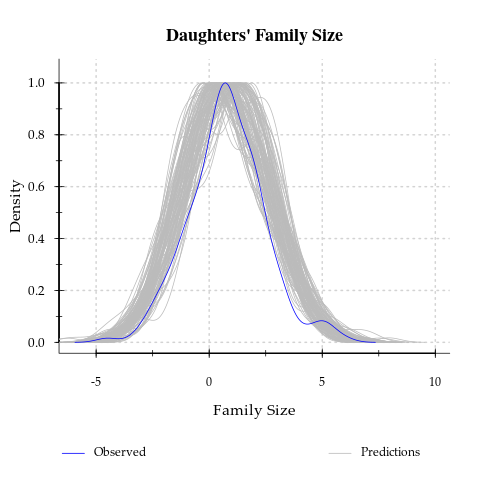

In [17]:
%%R
#   Loading Posterior Predictive Checks
    load("Two_Moms_Input_Data.Rdata")
    load("Two_Moms_Daughter_PostPred.Rdata")

#   Comparing the Observed Values with the Posterior Predictive Distributions
    par(family = "Palatino Linotype")
    fit_density <- fit_check_density(d_post_pred, "Family Size", data$D, "Daughters' Family Size", 100)

<div style="font-size:12pt; font-weight:bold;">Error Analysis Using Maximum a Posteriori (MAP) Estimation</div>

In [10]:
%%R
# Load Data
  setwd("/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/R_functions")
  load("Two_Moms_Data_Summary.Rdata")
  load("Two_Moms_Input_Data.Rdata")

# Isolate Daughters' MAP Estimates
  map_estimates <- row.names(rstan_summary)[grepl("y", row.names(rstan_summary))]
  daughter_map_estimates <- map_estimates[grepl(",2]", map_estimates)]
  model_predictions <- data.frame(M = data$M, B2 = data$B2, D = data$D,
                                   map_est = rstan_summary[(row.names(rstan_summary) %in% daughter_map_estimates), "mean"])
  model_predictions$resid <- model_predictions$D - model_predictions$map_est
  
# Export to Dataplot
  setwd("/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Dataplot_functions")
  dataplot_export(model_predictions, "Two_Moms_MAP")
  setwd("/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/R_functions")

In [4]:
# Change Directory to Dataplot_functions
os.chdir('/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Dataplot_functions')

# Start a NIST Dataplot session
dp = pexpect.spawn("dataplot")

In [7]:
dp.sendline("CALL Two_Moms_SixPlot.DP")  # Define a variable
dp.expect(r">")

0

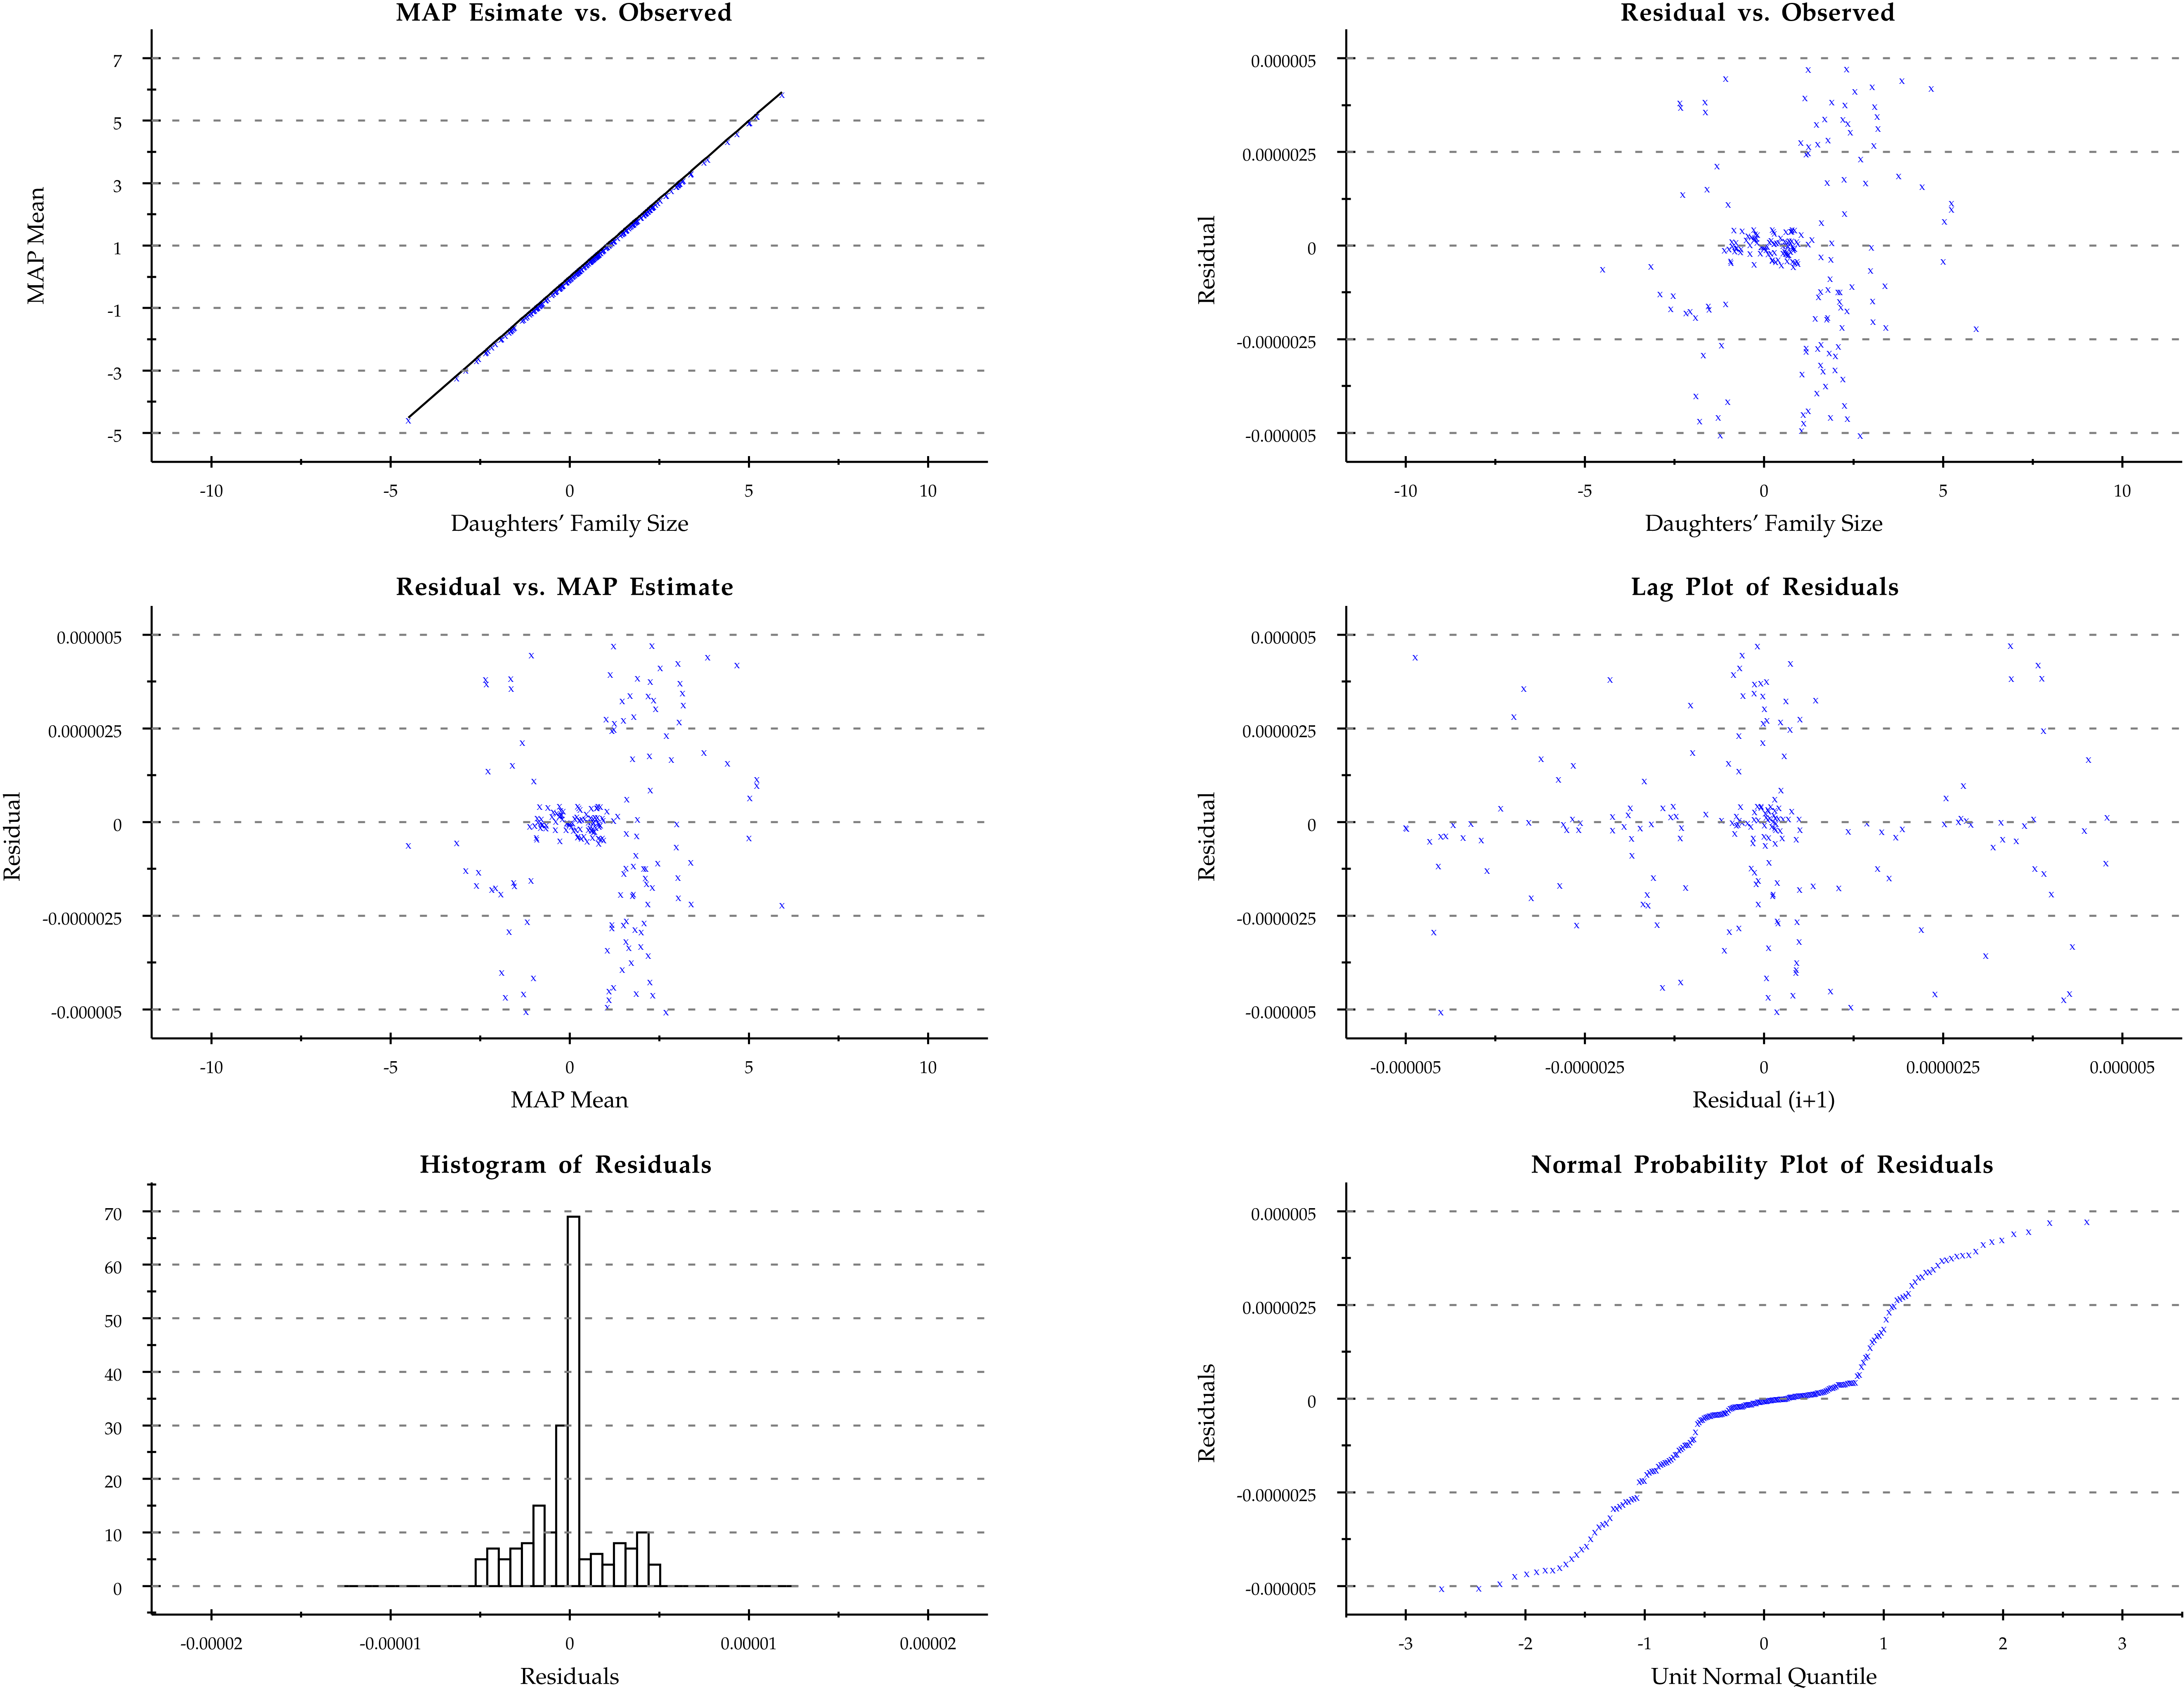

In [2]:
# Examining the Model Fit (Tail Behavior & Systematic Biases)
# The MAP is the bast possible fit with the data. 
# Consequently if we see problems here, then we will want to either consider the model specification, features of the data, or both.
file_path = "/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Analyses/Figures/Two_Moms_6Plot.png"
img = Image.open(file_path)
display(img)

In [9]:
dp.sendline("CALL Two_Moms_QQPlot.DP")  # Define a variable
dp.expect(r">")

0

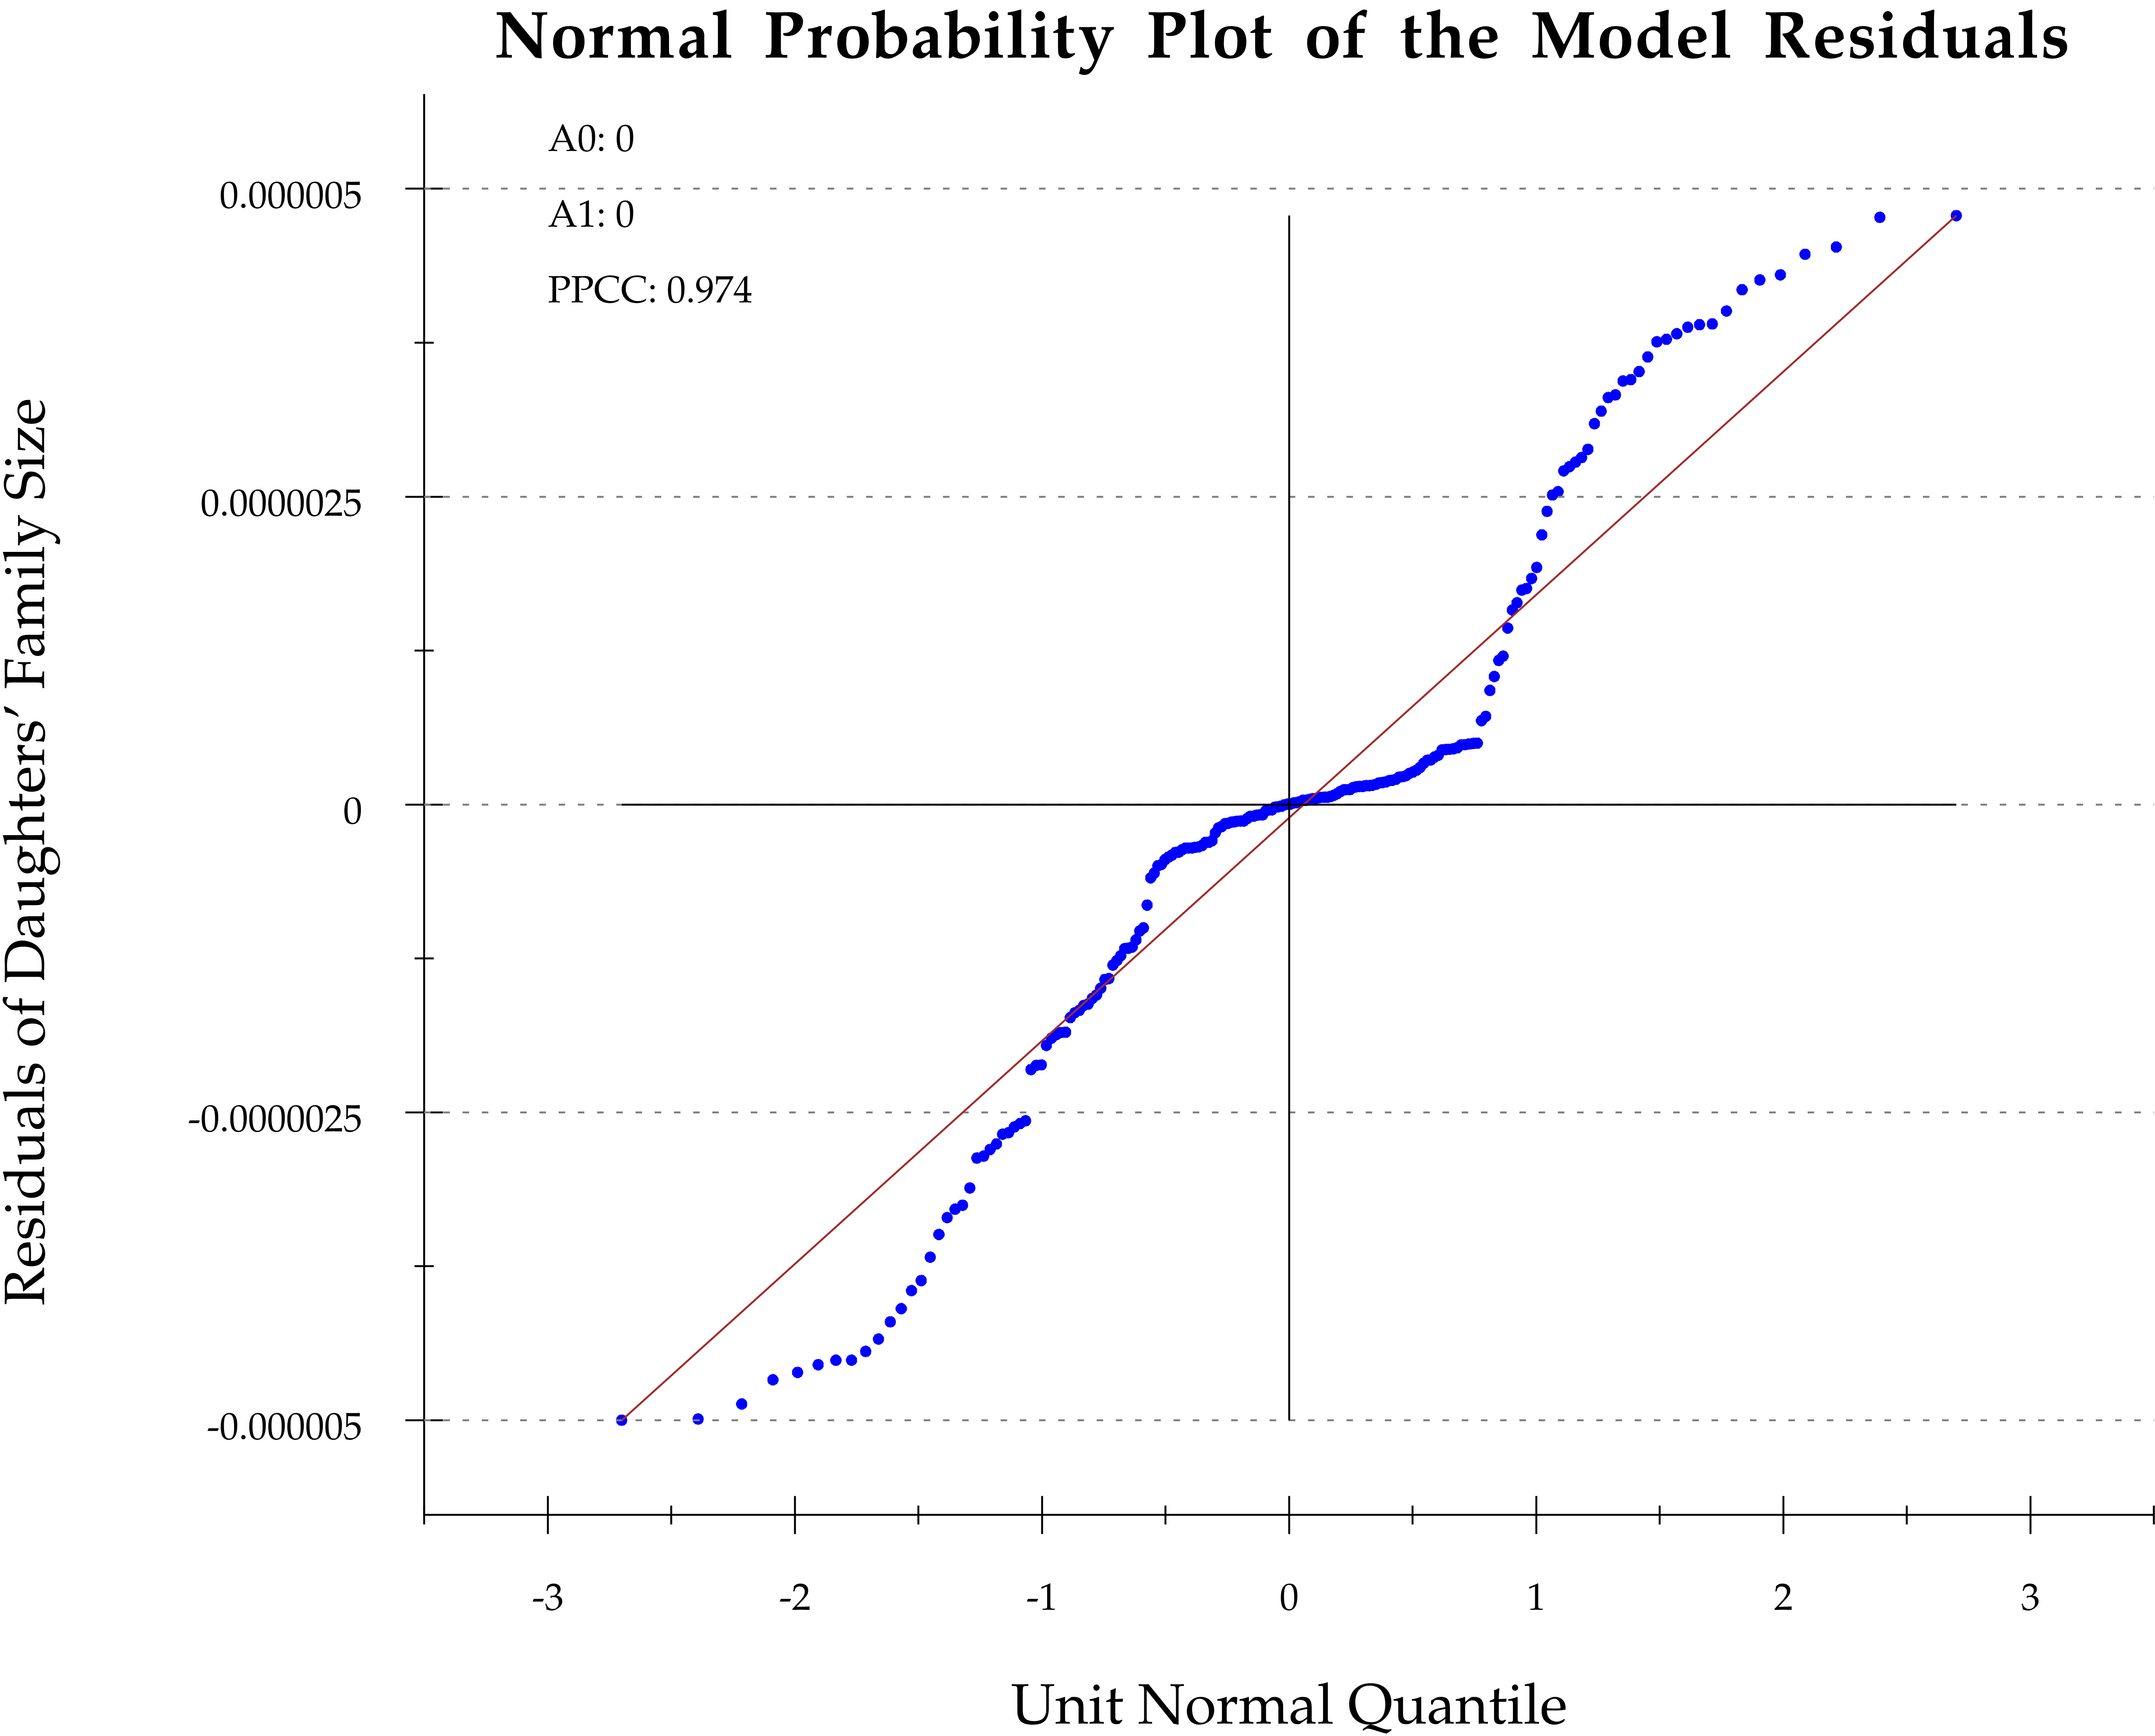

In [10]:
# Examining the Model Fit (Tail Behavior & Systematic Biases)
# Indicated here by extreme deviations away from the reference line.
# The distribution is more peaked with shorter tails than a Gaussian, indicating a weaker fit at the tails of the family size distribution.
file_path = "/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Analyses/Figures/Two_Moms_QQPlot.png"
img = Image.open(file_path)
display(img)

In [5]:
dp.sendline("CALL Two_Moms_RFPlot.DP")  # Define a variable
dp.expect(r">")

0

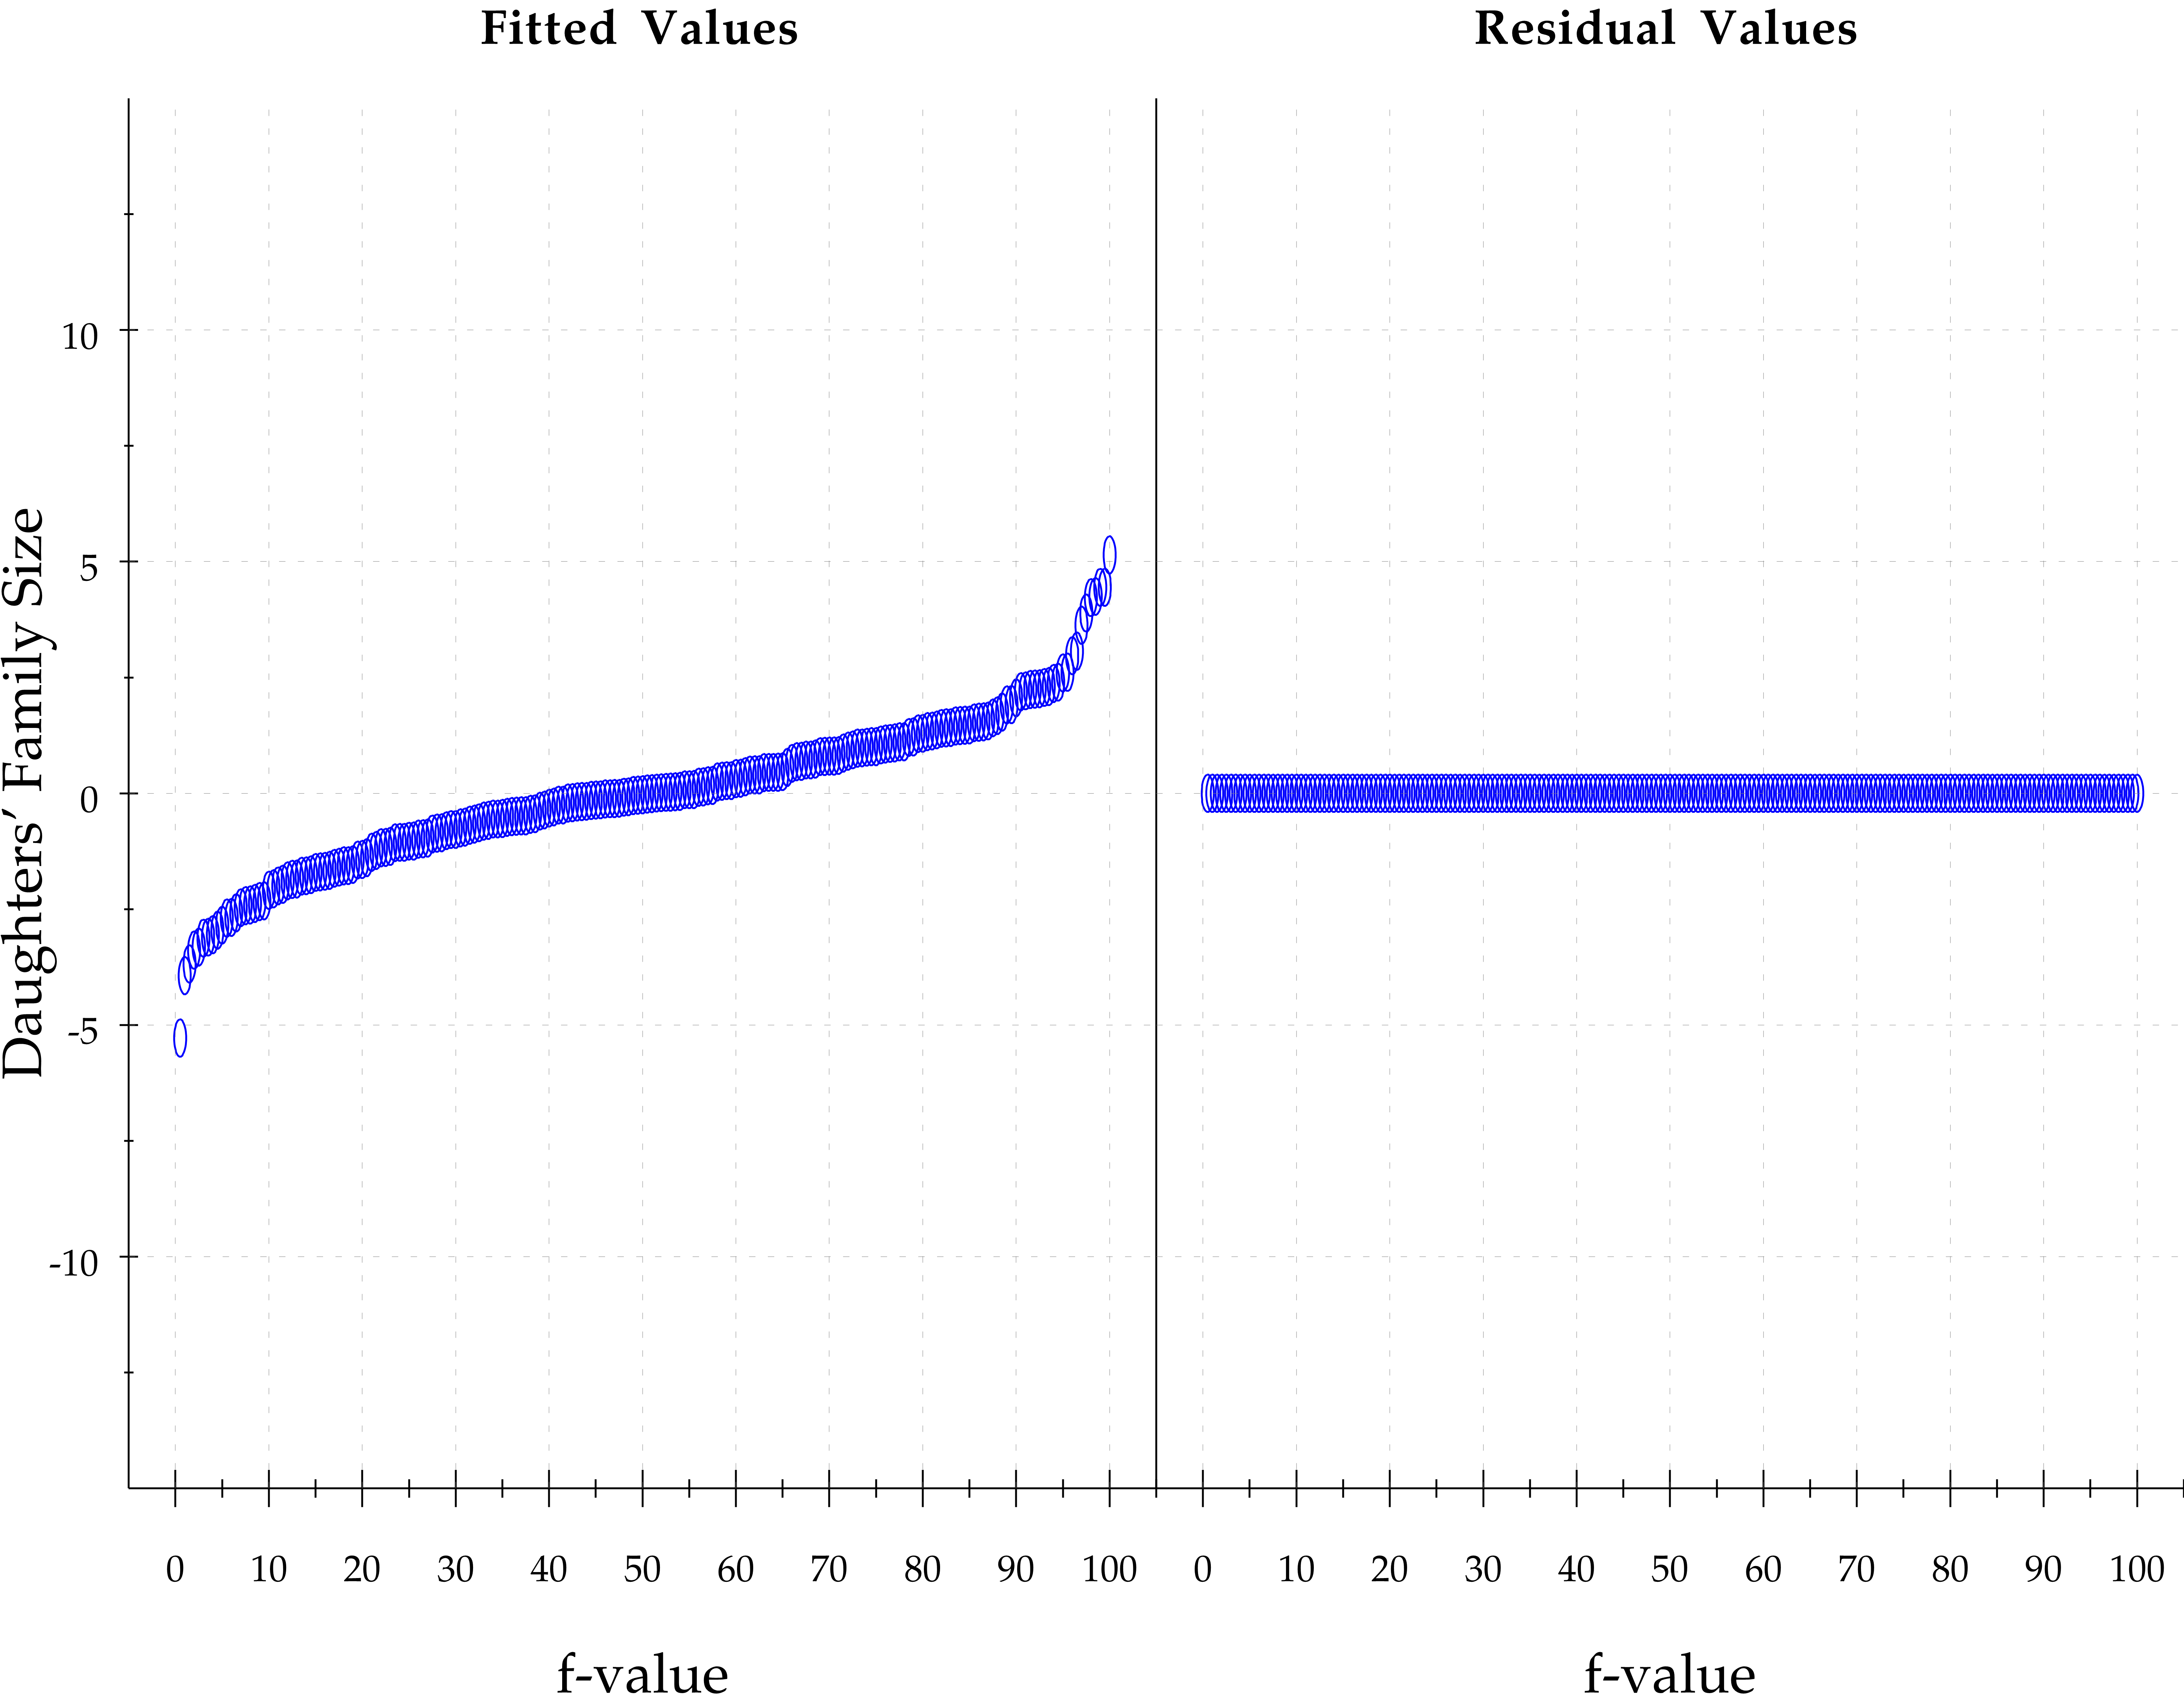

In [6]:
file_path = "/mnt/d/GitHub_Repositories/Netanomics_Analysts_Collaborative_Environment/Workflow_Demonstration/Analyses/Figures/Two_Moms_RFSpread_Plot.png"
img = Image.open(file_path)
display(img)

In [15]:
# Exiting Dataplot for Now
dp.sendline("exit")  
dp.expect(r">")

0

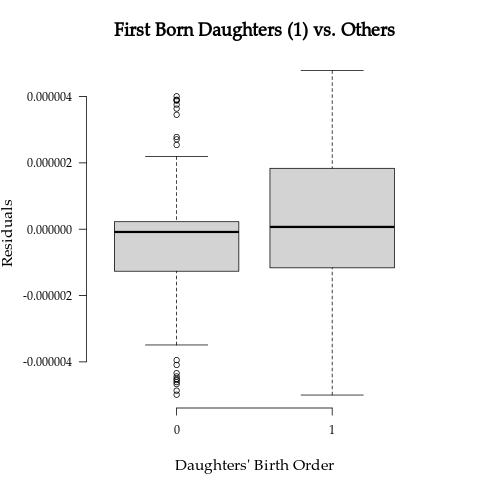

In [11]:
%%R
#   Plotting Residual Fit with Respect to Daughter Birth Order
    par(mar = c(5, 6, 4, 4), family = "Palatino Linotype")
    boxplot(resid ~ B2, data = model_predictions, frame = FALSE, las=1, xlab='', ylab=' ')
    
    mtext(side = 1, text="Daughters' Birth Order", line = 3.5, cex = 1.3)
    mtext(side = 2, text="Residuals", 5, cex = 1.3)
    
    title("First Born Daughters (1) vs. Others", cex.main=1.5, line=1.5)

<div style="font-size:10pt; font-weight:bold;">Fit Assessment</div>

<div style="font-size:10pt;">
<span style="display: block; margin-bottom: 1em;">
The MAP mean residuals, ranging from -0.000004999659 to 0.000004782386, indicate a strong model fit. If this was actual data, the posterior predictive checks would indicate that this model is likely to generalize well to similar settings. As expected, the model struggles most at the tails of the daughters' family size distribution. This is evident in both the posterior predictive checks and the residual fit plots.
</span>

<span style="display: block; margin-bottom: 1em;">
Lastly, the birth-order box plots reveal that the model fit is weaker for firstborn daughters. This observation aligns with the behavior at the tails of the distribution, as this group often features larger family sizes compared to the overall sample, including many positive outliers.
</span>
</div>